In [1]:
from PIL import Image
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from cv2 import cv2 as cv
import numpy as np
import requests
import zipfile
import tarfile
import rarfile
import io
import py7zr
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Conv2DTranspose, ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
os.makedirs('res', exist_ok=True)
os.makedirs('res/DIBCO18', exist_ok=True)
os.makedirs('res/DIBCO17', exist_ok=True)
os.makedirs('res/DIBCO16', exist_ok=True)
def fetch_data(link, location):
    filename = os.path.join(location, link.split('/')[-1])
    print(f"Downloading from {link}")
    response = requests.get(link)
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename, "r") as file:
            file.extractall(location)
            print(f'Extracted {filename}')

    elif filename.endswith(".7z"):
        with py7zr.SevenZipFile(filename, mode="r") as file:
            file.extractall(location)
            print(f'Extracted {filename}')
            
    elif filename.endswith(".tar.gz"):
        with tarfile.open(filename, "r:gz") as file:
            file.extractall(location)
            print(f'Extracted {filename}')

    elif filename.endswith(".rar"):
        with rarfile.RarFile(filename) as file:
            file.extractall(location)
            print(f'Extracted {filename}')
    else:
        print('WARNING: Unknown file format to fetch data from')
        
    os.remove(filename)
    
fetch_data('https://vc.ee.duth.gr/h-dibco2018/benchmark/dibco2018_Dataset.zip', 'res/DIBCO18')
fetch_data('https://vc.ee.duth.gr/h-dibco2018/benchmark/dibco2018-GT.zip', 'res/DIBCO18')
fetch_data('https://vc.ee.duth.gr/dibco2017/benchmark/DIBCO2017_Dataset.7z', 'res/DIBCO17')
fetch_data('https://vc.ee.duth.gr/dibco2017/benchmark/DIBCO2017_GT.7z', 'res/DIBCO17')
fetch_data('https://vc.ee.duth.gr/h-dibco2016/benchmark/DIBCO2016_dataset-GT.zip', 'res/DIBCO16')
fetch_data('https://vc.ee.duth.gr/h-dibco2016/benchmark/DIBCO2016_dataset-original.zip', 'res/DIBCO16')

Extracted res/DIBCO18\dibco2018_Dataset.zip
Extracted res/DIBCO18\dibco2018-GT.zip
Extracted res/DIBCO17\DIBCO2017_Dataset.7z
Extracted res/DIBCO17\DIBCO2017_GT.7z
Extracted res/DIBCO16\DIBCO2016_dataset-GT.zip
Extracted res/DIBCO16\DIBCO2016_dataset-original.zip


In [3]:
def load_images(noisy_dirs, clean_dirs, img_size=(512, 256)):
    noisy_images = []
    clean_images = []
    num_of_dirs = len(noisy_dirs)
    if(num_of_dirs != len(clean_dirs)):
        print('Unequal number of clean directories to noisy!')
    else:
        for i in range(num_of_dirs):
            noise_files = os.listdir(noisy_dirs[i])
            clean_files = os.listdir(clean_dirs[i])
            for j in range(len(noise_files)):
                noisy_img = cv.resize(cv.imread(os.path.join(noisy_dirs[i], noise_files[j])), img_size)
                clear_img = cv.resize(cv.imread(os.path.join(clean_dirs[i], clean_files[j])), img_size)
                # noisy_img = cv.cvtColor(noisy_img, cv.COLOR_BGR2GRAY)
                # clear_img = cv.cvtColor(clear_img, cv.COLOR_BGR2GRAY)
                noisy_img = noisy_img / 255.0
                clear_img = clear_img / 255.0
                # noisy_img = np.expand_dims(noisy_img, axis=-1)  
                # clear_img = np.expand_dims(clear_img, axis=-1) 
                noisy_images.append(noisy_img)
                clean_images.append(clear_img) 
    return np.array(noisy_images), np.array(clean_images)

In [4]:
train_dirs = [
    #'res/DIBCO16/DIPCO2016_dataset',
    #'res/DIBCO17/Dataset',
    #'res/DIBCO18/dataset',
    #'res/kaggle_dirty_documents/train',
    'res/ShabbyPages/validate/validate/validate_shabby',
    'res/ShabbyPages/train/train/train_shabby'
]

train_clean_dirs = [
    #'res/DIBCO16/DIPCO2016_Dataset_GT',
    #'res/DIBCO17/GT',
    #'res/DIBCO18/gt',
    #'res/kaggle_dirty_documents/train_cleaned',
    'res/ShabbyPages/validate/validate/validate_cleaned',
    'res/ShabbyPages/train/train/train_shabby'
]

noisy_images, clean_images = load_images(train_dirs, train_clean_dirs)
print(len(noisy_images))
print(len(clean_images))
X_train, X_test, y_train, y_test = train_test_split(noisy_images, clean_images, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)  # Expect (num_samples, 512, 256, 1)
print(y_train.shape)  # Expect (num_samples, 512, 256, 1)
print(X_test.shape)  # Expect (num_samples, 512, 256, 1)
print(y_test.shape)  # Expect (num_samples, 512, 256, 1)
print(X_val.shape)  # Expect (num_samples, 512, 256, 1)
print(y_val.shape)  # Expect (num_samples, 512, 256, 1)

1271
1271
(812, 256, 512, 3)
(812, 256, 512, 3)
(255, 256, 512, 3)
(255, 256, 512, 3)
(204, 256, 512, 3)
(204, 256, 512, 3)


In [5]:
print("Max value in X_train:", np.max(X_train))
print("Min value in X_train:", np.min(X_train))
print("Max value in y_train:", np.max(y_train))
print("Min value in y_train:", np.min(y_train))

Max value in X_train: 1.0
Min value in X_train: 0.0
Max value in y_train: 1.0
Min value in y_train: 0.0


In [11]:
train_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True        
)
val_test_generator = ImageDataGenerator()

train_dataset = train_generator.flow(X_train, y_train, batch_size=8)
val_dataset = val_test_generator.flow(X_test, y_test, batch_size=8)
test_dataset = val_test_generator.flow(X_val, y_val, batch_size=8)

In [23]:
model = tf.keras.models.Sequential()
model.add(Conv2D(64, (3, 3), activation=None, padding='same', input_shape=(256, 512, 3)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(1024, (3, 3), activation=None, padding='same'))
model.add(Dropout(0.15))
model.add(Conv2D(1024, (3, 3), activation=None, padding='same'))

model.add(Conv2DTranspose(512, (3, 3), strides=(2, 2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Conv2DTranspose(256, (3, 3), strides=(2, 2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), activation=None, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))
          
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse * 0.5 + 0.5 * (1 - ssim)  # Adjust weight as needed
    
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 256, 512, 64)      1792      
                                                                 
 batch_normalization_34 (Bat  (None, 256, 512, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_32 (ReLU)             (None, 256, 512, 64)      0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 128, 256, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 256, 128)     73856     
                                                                 
 batch_normalization_35 (Bat  (None, 128, 256, 128)   

In [14]:
model = tf.keras.models.Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 512, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mse * 0.5 + 0.5 * (1 - ssim)  # Adjust weight as needed
    
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 512, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 512, 128)     73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 256, 128)    0         
 2D)                                                             
                                                                 
 batch_normalization_18 (Bat  (None, 128, 256, 128)    512       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 128, 256, 128)     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 256, 128)    

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
history = model.fit(train_dataset,
         validation_data=val_dataset,
         epochs=10,
         batch_size=8,
         shuffle=True,
         verbose=1,
        callbacks=[lr_scheduler])

Epoch 1/10
102/102 [==============================] - 39s 351ms/step - loss: 0.0439 - mae: 0.1524 - val_loss: 0.0457 - val_mae: 0.1679 - lr: 0.0010
Epoch 2/10
102/102 [==============================] - 34s 330ms/step - loss: 0.0349 - mae: 0.1291 - val_loss: 0.0722 - val_mae: 0.2416 - lr: 0.0010
Epoch 3/10
102/102 [==============================] - 33s 324ms/step - loss: 0.0351 - mae: 0.1303 - val_loss: 0.0305 - val_mae: 0.1155 - lr: 0.0010
Epoch 4/10
102/102 [==============================] - 33s 320ms/step - loss: 0.0340 - mae: 0.1263 - val_loss: 0.0389 - val_mae: 0.1578 - lr: 0.0010
Epoch 5/10
102/102 [==============================] - 33s 321ms/step - loss: 0.0329 - mae: 0.1247 - val_loss: 0.0293 - val_mae: 0.1141 - lr: 0.0010
Epoch 6/10
102/102 [==============================] - 33s 321ms/step - loss: 0.0327 - mae: 0.1233 - val_loss: 0.0304 - val_mae: 0.1157 - lr: 0.0010
Epoch 7/10
102/102 [==============================] - 33s 320ms/step - loss: 0.0332 - mae: 0.1259 - val_loss: 0.

In [25]:
loss, acc = model.evaluate(test_dataset)
print(f'The accuracy of the model is {round(acc * 100, 2)}%')
print(f'The loss of the model is {round(loss, 4)}')
denoised_images = model.predict(test_dataset)
# fig, ax = plt.subplots(8, 4, figsize=(15, 35))
# batch_images, batch_true_labels = next(test_data_aug)
# batch_predictions = model.predict(batch_images)
# batch_true_indices = np.argmax(batch_true_labels, axis=1)
# batch_pred_indices = np.argmax(batch_predictions, axis=1)

# for i in range(32):
#     ax[i // 4, i % 4].imshow(batch_images[i].squeeze(), cmap='gray')
#     ax[i // 4, i % 4].axis('off')
#     ax[i // 4, i % 4].set_title(f'Predicted: {batch_pred_indices[i]}')
# #print('The batch's true indices are:')
# print(batch_true_indices)
# #print('The batch's predicted indices are:')
# print(batch_pred_indices)
# plt.imshow(batch_images[0].squeeze(), cmap='gray')

26/26 [==============================] - 3s 104ms/step - loss: 0.0306 - mae: 0.1091
The accuracy of the model is 10.91%
The loss of the model is 0.0306
26/26 [==============================] - 3s 101ms/step


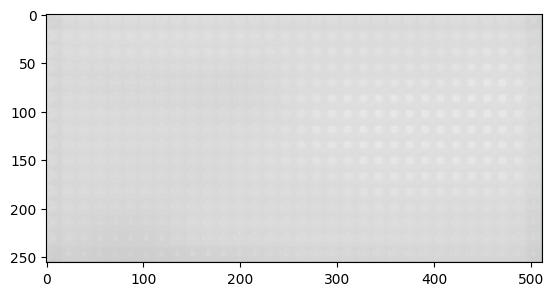

In [26]:
plt.imshow(denoised_images[0].squeeze(), cmap='gray')